# Load libraries, define constants, functions, and classes

* libraries we need

we directly import out 'basic model' from out test file

In [ ]:
import os

import sys
sys.path.append("../../2_train_and_test_models")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

import keras
from keras.utils import Sequence

from params import ROOT, Params
from BM.test import *
from seqdataloader.batchproducers.coordbased.core import Coordinates
from seqdataloader.batchproducers.coordbased.coordstovals.fasta import PyfaidxCoordsToVals
from matplotlib.pyplot import savefig

/net/talisker/home/benos/mae117/.conda/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-21 16:27:55.372980: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742588875.391885  479699 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742588875.397587  479699 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 16:27:55.418442: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructio

* classes

our generator here feeds in seqeunces from our train file

In [2]:
class UMAP_Generator(Sequence):
	def __init__(self, params, workers=1, use_multiprocessing=False, max_queue_size=10):
		super().__init__(workers=workers, use_multiprocessing=use_multiprocessing, max_queue_size=max_queue_size)
		self.params				= params
		self.posfile			= params.bindingtrainposfile
		self.negfile			= params.bindingtrainnegfile
		self.converter			= PyfaidxCoordsToVals(params.source_genome_file)
		self.batchsize			= params.umap_size # the only change here!
		self.halfbatchsize		= self.batchsize // 2
		self.steps_per_epoch	= params.train_steps
		self.total_epochs		= params.epochs
		self.current_epoch		= 0

		self.get_data()

	def __len__(self):
		return self.steps_per_epoch

	def __getitem__(self, batch_index):
		# (1) Get chunk of onehots
		pos_onehots_batch = self.pos_onehots[batch_index * self.halfbatchsize : (batch_index + 1) * self.halfbatchsize]
		neg_onehots_batch = self.neg_onehots[batch_index * self.halfbatchsize : (batch_index + 1) * self.halfbatchsize]
		assert pos_onehots_batch.shape[0] > 0, pos_onehots_batch.shape[0]
		assert neg_onehots_batch.shape[0] > 0, neg_onehots_batch.shape[0]

		# (2) We combine bound and unbound sites into one large array, and create 
		# label vector. We don't need to shuffle here because all these examples will
		# correspond to a simultaneous gradient update for the whole batch.
		all_seqs = np.concatenate((pos_onehots_batch, neg_onehots_batch))

		# Labels for binding prediction task
		binding_labels = np.concatenate((
			np.ones(pos_onehots_batch.shape[0],),
			np.zeros(neg_onehots_batch.shape[0],)
		))

		# Auxillary variable representing the domain index (species) for each example
		domain_labels = np.concatenate((
			np.ones(pos_onehots_batch.shape[0],) * self.params.domain_indices[self.params.source_species],
			np.ones(neg_onehots_batch.shape[0],) * self.params.domain_indices[self.params.source_species]
		))

		assert all_seqs.shape[0] == self.batchsize, all_seqs.shape[0]

		return {"sequence":all_seqs, "index":domain_labels}, binding_labels

	def get_data(self):
		''' Using current filenames stored in self.posfile and self.negfile,
			load in all of the training data as coordinates only.
			Then, when it is time to fetch individual batches, a chunk of
			coordinates will be converted into one-hot encoded sequences
			ready for model input.
		'''
		with open(self.posfile) as posf:
			pos_coords_tmp		= [line.split()[:3] for line in posf]  # expecting bed file format
			self.pos_coords		= [Coordinates(coord[0], int(coord[1]), int(coord[2])) for coord in pos_coords_tmp]  # no strand consideration
			self.pos_onehots	= self.converter(self.pos_coords)

		with open(self.negfile) as negf:
			neg_coords_tmp		= [line.split()[:3] for line in negf]
			self.neg_coords		= [Coordinates(coord[0], int(coord[1]), int(coord[2])) for coord in neg_coords_tmp]
			self.neg_onehots	= self.converter(self.neg_coords)

	def on_epoch_end(self):
		print(f"\n\nFinished training on the set (neg): {self.negfile}!\n")

		# (1) Switch to next set of negative examples
		prev_epoch = self.current_epoch
		self.current_epoch = prev_epoch + 1

		# (2) Update file where we will retrieve unbound site coordinates from
		prev_negfile = self.negfile
		next_negfile = prev_negfile.replace(str(prev_epoch) + "E", str(self.current_epoch) + "E")
		self.negfile = next_negfile

		if self.total_epochs < self.current_epoch:
			return
		else:
			# (3) Load in new unbound site coordinates
			with open(self.negfile) as negf:
				neg_coords_tmp = [line.split()[:3] for line in negf]
				self.neg_coords = [Coordinates(coord[0], int(coord[1]), int(coord[2])) for coord in neg_coords_tmp]
				self.neg_onehots = self.converter(self.neg_coords)
		
			# (4) Then shuffle positive examples
			self.pos_onehots = tf.random.shuffle(self.pos_onehots)

# Create toy data so we can input it through our model
* This is to showcase a 2-D projection of latent embedding of our base model, from here, we perform moment alignment operations to encourage domain-adaptation

In [3]:
model_name, tf, source_species, run = ["Testing", "RXRA", "mm10", 1]
args                                = [model_name, tf, source_species, run]
params                              = Params(args, verbose=True)
mouse_generator                     = UMAP_Generator(params)

{'batchsize': 400,
 'bindingtrainnegfile': '/net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/MORALE/two-species/data/mm10/RXRA/chr3toY_neg_shuf_run1_1E.bed',
 'bindingtrainposfile': '/net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/MORALE/two-species/data/mm10/RXRA/chr3toY_pos_shuf.bed',
 'convfilters': 240,
 'dl1nodes': 1024,
 'dl2nodes': 512,
 'domain_indices': {'hg38': 1, 'mm10': 0},
 'dropout': 0.5,
 'epochs': 15,
 'filtersize': 20,
 'lstmnodes': 32,
 'model_name': 'Testing',
 'modeldir': '/net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/MORALE/two-species/models/RXRA/mm10_trained/Testing',
 'modelfile': '/net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/MORALE/two-species/models/RXRA/mm10_trained/Testing/2025-03-21_16-27-58_run1',
 'pool_size': 15,
 'run': 1,
 'seqlen': 500,
 'source_genome_file': '/net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/MO

In [4]:
model_name, tf, source_species, run = ["Testing", "RXRA", "hg38", 1]
args                                = [model_name, tf, source_species, run]
params                              = Params(args, verbose=True)
human_generator                     = UMAP_Generator(params)

{'batchsize': 400,
 'bindingtrainnegfile': '/net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/MORALE/two-species/data/hg38/RXRA/chr3toY_neg_shuf_run1_1E.bed',
 'bindingtrainposfile': '/net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/MORALE/two-species/data/hg38/RXRA/chr3toY_pos_shuf.bed',
 'convfilters': 240,
 'dl1nodes': 1024,
 'dl2nodes': 512,
 'domain_indices': {'hg38': 1, 'mm10': 0},
 'dropout': 0.5,
 'epochs': 15,
 'filtersize': 20,
 'lstmnodes': 32,
 'model_name': 'Testing',
 'modeldir': '/net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/MORALE/two-species/models/RXRA/hg38_trained/Testing',
 'modelfile': '/net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/MORALE/two-species/models/RXRA/hg38_trained/Testing/2025-03-21_16-33-04_run1',
 'pool_size': 15,
 'run': 1,
 'seqlen': 500,
 'source_genome_file': '/net/talisker/home/benos/mae117/Documents/research/dennis/domain_adaptation/MO

In [5]:
full_model = basic_model(params)
full_model.summary()

# Extract the layers up to the embedding layer
layer_list      = full_model.layers[:5]
partial_model   = keras.Model(inputs=layer_list[1].input, outputs=layer_list[-1].output)

partial_model.summary()

I0000 00:00:1742589795.728617  479699 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14297 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:02:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ sequence            │ (None, 500, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 500, 240)  │     19,440 │ sequence[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 500, 240)  │          0 │ conv1d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 34, 240)   │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 32)        │     34,944 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │     33,792 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        513 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ index (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ dense_2[0][0]     │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 613,489 (2.34 MB)

 Trainable params: 613,489 (2.34 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence (InputLayer)           │ (None, 500, 4)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 500, 240)       │        19,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 500, 240)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 34, 240)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        34,944 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,384 (212.44 KB)

 Trainable params: 54,384 (212.44 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
mouse_seq = mouse_generator.__getitem__(0)[0]['sequence']
human_seq = human_generator.__getitem__(0)[0]['sequence']

mouse_idx = mouse_generator.__getitem__(0)[0]['index']
human_idx = human_generator.__getitem__(0)[0]['index']

joint_seq = np.concatenate((mouse_seq, human_seq))
joint_idx = np.concatenate((mouse_idx, human_idx))

# Create embedding with toy data and our partial model

In [7]:
latent_embedding = partial_model.predict(joint_seq)
latent_embedding.shape

I0000 00:00:1742589799.424726  480799 cuda_dnn.cc:529] Loaded cuDNN version 90300


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


(10000, 32)

In [9]:
np.save(f"{ROOT}/plots/Figure1/latent_embedding_sequence", latent_embedding)

In [10]:
np.save(f"{ROOT}/plots/Figure1/latent_embedding_index", joint_idx)

# Calculate covariance from the saved latent embedding

In [11]:
sns.set(style='white', context='poster', rc={'figure.figsize':(14,10)})

latent_embedding    = np.load(f"{ROOT}/plots/Figure1/latent_embedding_sequence.npy")
index               = np.load(f"{ROOT}/plots/Figure1/latent_embedding_index.npy")

In [12]:
mouse_embedding = latent_embedding[index == 0]
human_embedding = latent_embedding[index == 1]

In [13]:
# Calculate the covariance matrix
#covariance_matrix = np.cov(xc, rowvar=False)

m, d = mouse_embedding.shape

# source covariance
xm = np.mean(mouse_embedding, axis=0, keepdims=True) - mouse_embedding
xc = np.matmul(xm.T, xm)

# target covariance
xmt = np.mean(human_embedding, axis=0, keepdims=True) - human_embedding
xct = np.matmul(xmt.T, xmt)

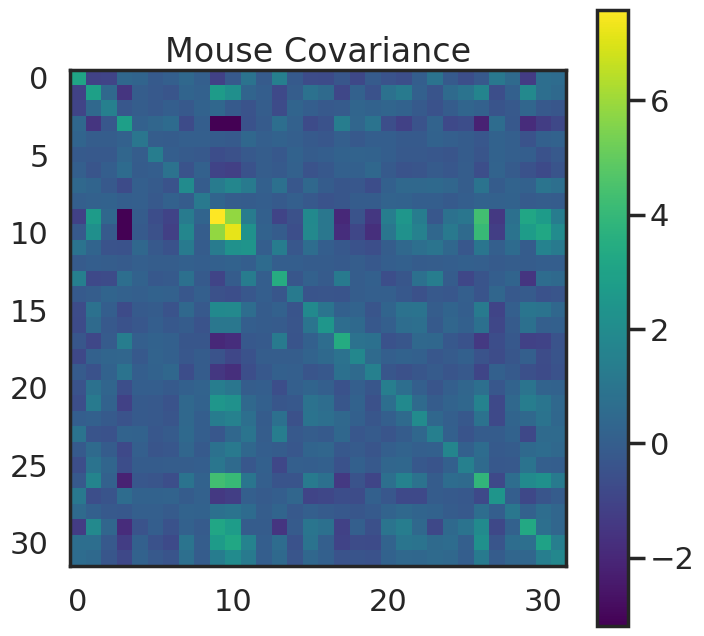

In [ ]:
# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(xc, cmap='viridis', interpolation='nearest')
plt.colorbar() # label='Covariance'
plt.title('Mouse Covariance')

savefig(
    f"{ROOT}/plots/Figure1/mouse_covariance.svg", transparent=True, dpi='figure', format='svg'
)

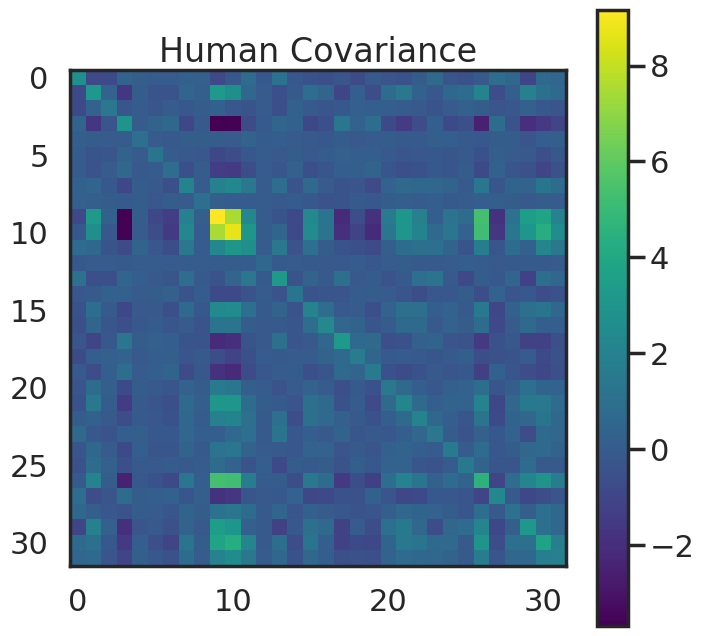

In [ ]:
# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(xct, cmap='viridis', interpolation='nearest')
plt.colorbar() # label='Covariance'
plt.title('Human Covariance')

savefig(
    f"{ROOT}/plots/Figure1/human_covariance.svg", transparent=True, dpi='figure', format='svg'
)

# Create UMAP from the saved latent embedding

In [20]:
def draw_umap(n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(latent_embedding);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=latent_embedding.mean(axis=1))
    if n_components == 2:
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=latent_embedding.mean(axis=1))
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(u[:,0], u[:,1], u[:,2], c=latent_embedding.mean(axis=1), s=100)
    plt.title(title, fontsize=18)

/net/talisker/home/benos/mae117/.conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


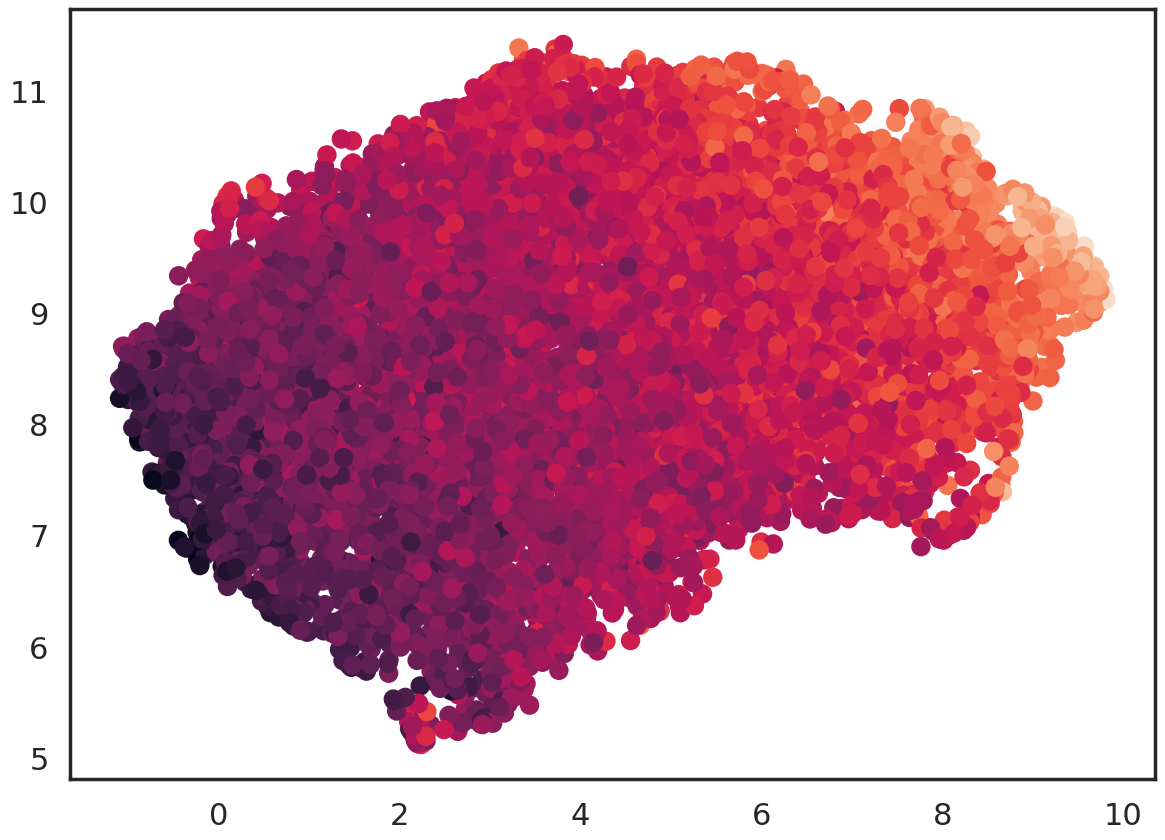

In [21]:
umap_fig = draw_umap()

savefig(
    f"{ROOT}/plots/Figure1/UMAP.svg", transparent=True, dpi='figure', format='svg'
)

-----